# Gridsearching a Decision Tree & Random Forest, to find best hyperparameter values

## Import dependencies, load data

In [47]:
from preprocessor import data_cleaner, data_sampler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score,GridSearchCV

from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, roc_curve,auc, confusion_matrix

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})


In [8]:
X_train, y_train = data_cleaner("../data/train.csv.zip")
X_test, y_test = data_cleaner("../data/test.csv.zip")
X_train, y_train = data_sampler(X_train,y_train)

## Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

### First gridsearch
My best guess at a range of values to test

In [10]:
dtc_grid = DecisionTreeClassifier()

# define parameter grid to search
grid = [
    {'criterion': ['gini', 'entropy', 'log_loss'], 
    'splitter': ['best','random'], 
    'max_depth': [2,5,10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,5,10],
    'max_features':[None,'auto'],
    'max_leaf_nodes':[10,50,100]}
]

gridsearch = GridSearchCV(estimator=dtc_grid,param_grid=grid,scoring='f1',cv=5,n_jobs=3)
gridsearch.fit(X_train,y_train)

grid_pred = gridsearch.predict(X_test)
grid_report = classification_report(y_test,grid_pred,output_dict=True)
grid_report = pd.DataFrame(grid_report).iloc[:,0:3]
grid_report

,0,1,accuracy
precision,0.988995,0.692645,0.913459
recall,0.903905,0.955616,0.913459
f1-score,0.944538,0.803152,0.913459
support,21177.000000,4799.000000,0.913459


In [11]:
gridsearch.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'splitter': 'best'}

### second gridsearch
The values with the greatest magnitude were chosen for Max_depth, max_features,max_leaf_nodes,min_samples_leaf.
So the next gridsearch will include these chosen values as the low end of the range that is being searched. 

In [12]:
grid_two = [
    {'criterion': ['gini'],
    'max_depth': [10,25,50],
    'max_features': ['log2',10,20],
    'max_leaf_nodes': [100,150,200],
    'min_samples_leaf': [10,25,50],
    'min_samples_split': [2],
    'splitter': ['best']}
]

gridsearch_two = GridSearchCV(estimator=dtc_grid,param_grid=grid_two,scoring='f1',cv=5,n_jobs=3)
gridsearch_two.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid=[{'criterion': ['gini'], 'max_depth': [10, 25, 50],
                          'max_features': ['log2', 10, 20],
                          'max_leaf_nodes': [100, 150, 200],
                          'min_samples_leaf': [10, 25, 50],
                          'min_samples_split': [2], 'splitter': ['best']}],
             scoring='f1')

In [13]:

grid_two_pred = gridsearch_two.predict(X_test)
grid_two_report = classification_report(y_test,grid_two_pred,output_dict=True)
grid_two_report = pd.DataFrame(grid_two_report).iloc[:,0:3]
grid_two_report

,0,1,accuracy
precision,0.989466,0.725893,0.925277
recall,0.918119,0.956866,0.925277
f1-score,0.952458,0.825528,0.925277
support,21177.000000,4799.000000,0.925277


In [14]:
gridsearch_two.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 20,
 'max_leaf_nodes': 200,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

### third gridsearch
Max_depth, max_leaf_nodes, continue selecting the greatest value. Max_features is still unclear. 

In [15]:
grid_three = [
    {'criterion': ['gini'],
    'max_depth': [50,100,200],
    'max_features': [15,20,23],
    'max_leaf_nodes': [200,300,500],
    'min_samples_leaf': [10],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridsearch_three = GridSearchCV(estimator=dtc_grid,param_grid=grid_three,scoring='f1',cv=5,n_jobs=3)
gridsearch_three.fit(X_train,y_train)

grid_three_pred = gridsearch_three.predict(X_test)
grid_three_report = classification_report(y_test,grid_three_pred,output_dict=True)
grid_three_report = pd.DataFrame(grid_three_report).iloc[:,0:3]
grid_three_report

,0,1,accuracy
precision,0.989434,0.776011,0.940868
recall,0.937479,0.955824,0.940868
f1-score,0.962756,0.856583,0.940868
support,21177.000000,4799.000000,0.940868


In [16]:
gridsearch_three.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 20,
 'max_leaf_nodes': 500,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

### fourth gridsearch
Everything seems to be getting zeroed in on except for max_leaf_nodes.

In [17]:
grid_four = [
    {'criterion': ['gini'],
    'max_depth': [75,100,125],
    'max_features': [18,19,20],
    'max_leaf_nodes': [500,750,1000],
    'min_samples_leaf': [5,10,15],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridesearch_four = GridSearchCV(estimator=dtc_grid,param_grid=grid_four,scoring='f1',cv=5,n_jobs=3)
gridesearch_four.fit(X_train,y_train)

grid_four_pred = gridesearch_four.predict(X_test)
grid_four_report = classification_report(y_test,grid_four_pred,output_dict=True)
grid_four_report = pd.DataFrame(grid_four_report).iloc[:,0:3]
grid_four_report

,0,1,accuracy
precision,0.990187,0.766911,0.938597
recall,0.933938,0.959158,0.938597
f1-score,0.961240,0.852328,0.938597
support,21177.000000,4799.000000,0.938597


In [18]:
gridesearch_four.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 20,
 'max_leaf_nodes': 750,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

### fifth gridsearch

In [19]:
grid_five = [
    {'criterion': ['gini'],
    'max_depth': [115,125,150,175],
    'max_features': [19],
    'max_leaf_nodes': [600,750,900],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridsearch_five = GridSearchCV(estimator=dtc_grid,param_grid=grid_five,scoring='f1',cv=5,n_jobs=3)
gridsearch_five.fit(X_train,y_train)

grid_five_pred = gridsearch_five.predict(X_test)
grid_five_report = classification_report(y_test,grid_five_pred,output_dict=True)
grid_five_report = pd.DataFrame(grid_five_report).iloc[:,0:3]
grid_five_report

,0,1,accuracy
precision,0.990882,0.796239,0.947451
recall,0.944232,0.961659,0.947451
f1-score,0.966995,0.871166,0.947451
support,21177.000000,4799.000000,0.947451


In [20]:
gridsearch_five.best_params_

{'criterion': 'gini',
 'max_depth': 150,
 'max_features': 19,
 'max_leaf_nodes': 600,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

### sixth gridsearch

In [21]:
grid_six = [
    {'criterion': ['gini'],
    'max_depth': [125,135,150],
    'max_features': [19],
    'max_leaf_nodes': [550,600,650],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'splitter': ['best']}
    ]

gridsearch_six = GridSearchCV(estimator=dtc_grid,param_grid=grid_six,scoring='f1',cv=5,n_jobs=3)
gridsearch_six.fit(X_train,y_train)

grid_six_pred = gridsearch_six.predict(X_test)
grid_six_report = classification_report(y_test,grid_six_pred,output_dict=True)
grid_six_report = pd.DataFrame(grid_six_report).iloc[:,0:3]
grid_six_report

,0,1,accuracy
precision,0.990262,0.760654,0.936749
recall,0.931577,0.959575,0.936749
f1-score,0.960023,0.848613,0.936749
support,21177.000000,4799.000000,0.936749


### Observations:
F1, precision, and recall performance continue to decrease after the fourth gridsearch. So, the the best_params_ of gridsearch_four will be used as a start point to gridsearch a random forest and bagging tree. 

Gridsearch_four.best_params_ returns the following dict:  
{'criterion': 'gini',  
 'max_depth': 125,  
 'max_features': 19,  
 'max_leaf_nodes': 750,  
 'min_samples_leaf': 5,  
 'min_samples_split': 2,  
 'splitter': 'best'}  

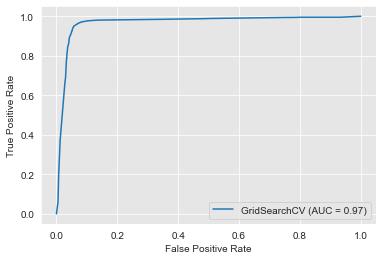

In [22]:
plot_roc_curve(gridesearch_four,X_test,y_test)
plt.show()

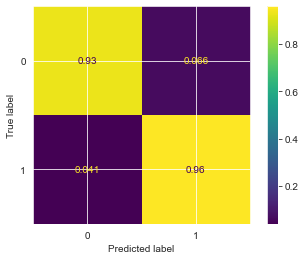

In [23]:
plot_confusion_matrix(gridesearch_four,X_test,y_test,normalize='true')
plt.show()

## BaggingClassifier

### baseline model (default bagging parameters)

In [24]:
bagging_tree = DecisionTreeClassifier(criterion='gini',
                                        max_depth=125,
                                        max_features=19,
                                        max_leaf_nodes=750,
                                        min_samples_leaf=5,
                                        min_samples_split=2,
                                        splitter='best')
                                        
tree_bagger = BaggingClassifier(base_estimator=bagging_tree)
tree_bagger.fit(X_train,y_train)
tree_bagger_pred = tree_bagger.predict(X_test)
tree_bagger_report = classification_report(y_test,tree_bagger_pred,output_dict=True)
tree_bagger_report = pd.DataFrame(tree_bagger_report).iloc[:,0:3]
tree_bagger_report


,0,1,accuracy
precision,0.992942,0.794981,0.948298
recall,0.943288,0.970411,0.948298
f1-score,0.967478,0.873980,0.948298
support,21177.000000,4799.000000,0.948298


### Gridsearch bagging classifier

#### First gridsearch

In [25]:
from sklearn.ensemble import BaggingClassifier

bagging_tree = DecisionTreeClassifier(criterion='gini',
                                        max_depth=125,
                                        max_features=19,
                                        max_leaf_nodes=750,
                                        min_samples_leaf=5,
                                        min_samples_split=2,
                                        splitter='best')

tree_bagger = BaggingClassifier()

bag_grid = [{
    'base_estimator':[bagging_tree], 
    'n_estimators':[5,10,15,20], 
    'max_samples':[1.0,3.0,5.0], 
    'max_features':[1.0,5.0,10.0],
    'bootstrap':[True,False],
    'bootstrap_features':[True,False], 
    'n_jobs':[3]
}]

bagged_grid = GridSearchCV(estimator=tree_bagger,param_grid=bag_grid,scoring='f1',n_jobs=3)
bagged_grid.fit(X_train,y_train)
bagged_grid_pred = bagged_grid.predict(X_test)
bagged_grid_report = classification_report(y_test,bagged_grid_pred,output_dict=True)
bagged_grid_report = pd.DataFrame(bagged_grid_report).iloc[:,0:3]
bagged_grid_report


,0,1,accuracy
precision,0.993654,0.783498,0.945411
recall,0.939038,0.973536,0.945411
f1-score,0.965574,0.868240,0.945411
support,21177.000000,4799.000000,0.945411


In [26]:
bagged_grid_report

,0,1,accuracy
precision,0.993654,0.783498,0.945411
recall,0.939038,0.973536,0.945411
f1-score,0.965574,0.868240,0.945411
support,21177.000000,4799.000000,0.945411


In [27]:
bagged_grid.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=125, max_features=19, max_leaf_nodes=750,
                        min_samples_leaf=5),
 'bootstrap': False,
 'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 20,
 'n_jobs': 3}

#### Second gridsearch 
-searching only n_estimators

In [28]:
second_bag_grid = [{
    'base_estimator':[bagging_tree], 
    'n_estimators':[20,23,25,30], 
    'max_samples':[1.0], 
    'max_features':[1.0],
    'bootstrap':[False],
    'bootstrap_features':[True], 
    'n_jobs':[3]
}]

second_bagged_grid = GridSearchCV(estimator=tree_bagger,param_grid=second_bag_grid,scoring='f1',n_jobs=3)
second_bagged_grid.fit(X_train,y_train)
second_bagged_grid_pred = second_bagged_grid.predict(X_test)
second_bagged_grid_report = classification_report(y_test,second_bagged_grid_pred,output_dict=True)
second_bagged_grid_report = pd.DataFrame(second_bagged_grid_report).iloc[:,0:3]
second_bagged_grid_report

,0,1,accuracy
precision,0.994374,0.795316,0.949222
recall,0.943051,0.976453,0.949222
f1-score,0.968033,0.876625,0.949222
support,21177.000000,4799.000000,0.949222


In [29]:
second_bagged_grid.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=125, max_features=19, max_leaf_nodes=750,
                        min_samples_leaf=5),
 'bootstrap': False,
 'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 30,
 'n_jobs': 3}

#### finding best n_estimators
Here I re-run the same cell(s) adjusting only n_estimators to find the value that improves F1 the most. 

In [30]:
n_trees_bagger = BaggingClassifier(base_estimator=bagging_tree,
                                    bootstrap=False,
                                    bootstrap_features=True,
                                    n_estimators=31,
                                    n_jobs=3)

n_trees_bagger.fit(X_train,y_train)

n_trees_pred = n_trees_bagger.predict(X_test)
n_trees_report = classification_report(y_test,n_trees_pred,output_dict=True)
n_trees_report = pd.DataFrame(n_trees_report).iloc[:,0:3]
n_trees_report

,0,1,accuracy
precision,0.993741,0.799624,0.950069
recall,0.944704,0.973745,0.950069
f1-score,0.968602,0.878136,0.950069
support,21177.000000,4799.000000,0.950069


#### Observations:
The best performing Bagging classifier is the second grid searches best parameters

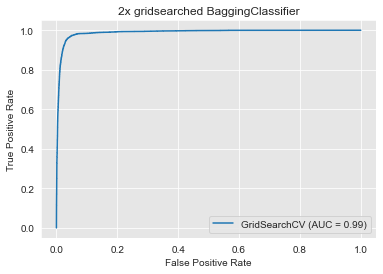

In [46]:
plot_roc_curve(second_bagged_grid,X_test,y_test)
plt.title('2x gridsearched BaggingClassifier')
plt.show()

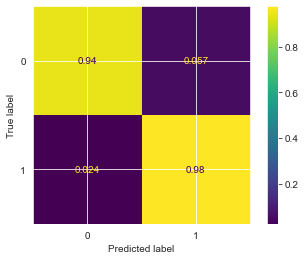

In [32]:
plot_confusion_matrix(second_bagged_grid,X_test,y_test,normalize='true')
plt.show()

## Random Forest

### Baseline RF

In [33]:
RFC = RandomForestClassifier(n_jobs=3)
RFC.fit(X_train,y_train)

rfc_pred = RFC.predict(X_test)
rfc_report = classification_report(y_test,rfc_pred,output_dict='true')
rfc_report = pd.DataFrame(rfc_report).iloc[:,0:3]
rfc_report

,0,1,accuracy
precision,0.994775,0.824925,0.957576
recall,0.952968,0.977912,0.957576
f1-score,0.973423,0.894928,0.957576
support,21177.000000,4799.000000,0.957576


### Tuning RF hyperparameters 
using the best_params_ from the decision tree model gridsearch_four

In [34]:
RFC_tuned = RandomForestClassifier(criterion='entropy',
                                    max_depth=125,
                                    max_features=20,
                                    max_leaf_nodes=750,
                                    min_samples_leaf=5,
                                    min_samples_split=2)
RFC_tuned.fit(X_train,y_train)

rfc_tuned_pred = RFC_tuned.predict(X_test)

rfc_tuned_report = classification_report(y_test,rfc_tuned_pred,output_dict='true')
rfc_tuned_report = pd.DataFrame(rfc_tuned_report).iloc[:,0:3]
rfc_tuned_report

,0,1,accuracy
precision,0.994284,0.799727,0.950416
recall,0.944610,0.976037,0.950416
f1-score,0.968811,0.879129,0.950416
support,21177.000000,4799.000000,0.950416


### Observations:
Random forest default settings consistently outperforms parameters used from best decision tree.  
Computational demands are too great to perform a gridsearch 

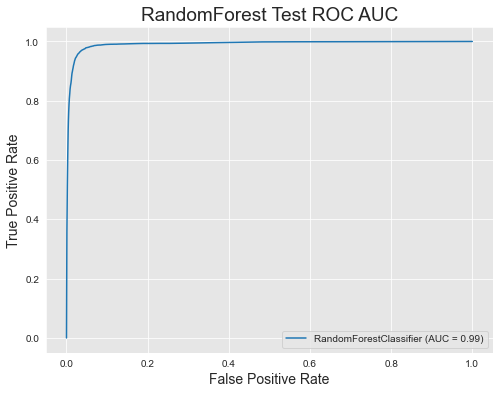

In [182]:
# baseline Random Forest ROC AUC
fig, ax = plt.subplots(figsize=(8, 6))
plot_roc_curve(RFC,X_test,y_test,ax=ax)
ax.set_title("RandomForest Test ROC AUC",fontsize=19)
ax.set_ylabel('True Positive Rate',fontsize=14)
ax.set_xlabel('False Positive Rate',fontsize=14)
plt.show()

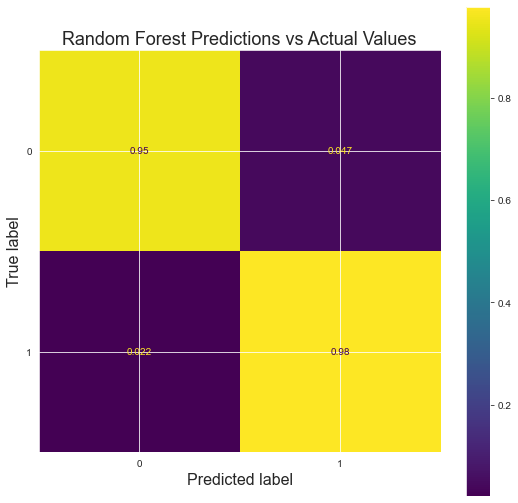

In [172]:
# baseline Random Forest confusion matrix
fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(RFC,X_test,y_test,normalize='true',ax=ax)
ax.set_title("Random Forest Predictions vs Actual Values",fontsize=18)
ax.set_ylabel('True label',fontsize=16)
ax.set_xlabel('Predicted label',fontsize=16)
plt.show()

## Iterative Performance Visualization

## F1 Score

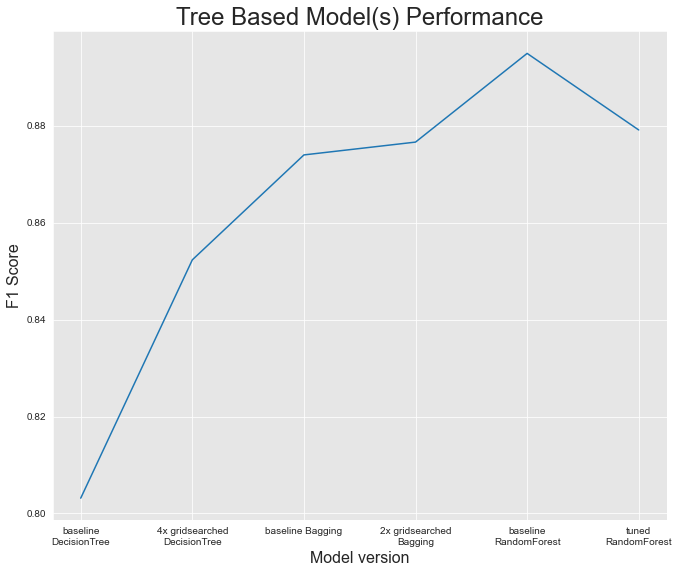

In [146]:
f1_scores = [
        grid_report['1'][2],
        grid_four_report['1'][2],
        tree_bagger_report['1'][2],
        second_bagged_grid_report['1'][2],
        rfc_report['1'][2],
        rfc_tuned_report['1'][2]
        ]

plt.figure(figsize=(11,9))
x = ['baseline\nDecisionTree',
        '4x gridsearched\nDecisionTree',
        'baseline Bagging',
        '2x gridsearched\nBagging',
        'baseline\nRandomForest',
        'tuned\nRandomForest']
y = f1_scores
plt.plot(x,y)

plt.title('Tree Based Model(s) Performance',fontsize=24)
plt.ylabel('F1 Score',fontsize=16)
plt.xlabel('Model version',fontsize=16)
plt.show()

## ROC AUC Curve

In [38]:
# calculate auc's
# first decision tree gridsearch 
base_gridsearch_fpr , base_gridsearch_tpr, base_gridsearch_thresholds = roc_curve(y_test, grid_pred)
base_gridsearch_auc = auc(base_gridsearch_fpr, base_gridsearch_tpr)

# best (fourth) decision tree gridsearch
gridsearch_four_fpr , gridsearch_four_tpr, gridsearch_four_thresholds = roc_curve(y_test, grid_four_pred)
gridsearch_four_auc = auc(gridsearch_four_fpr, gridsearch_four_tpr)

# baseline bagging 
base_bagging_fpr , base_bagging_tpr, base_bagging_thresholds = roc_curve(y_test, tree_bagger_pred)
base_bagging_auc = auc(base_bagging_fpr, base_bagging_tpr)

# second gridsearched bagging
second_grid_bagging_fpr , second_grid_bagging_tpr, second_grid_bagging_thresholds = roc_curve(y_test, second_bagged_grid_pred)
second_grid_bagging_auc = auc(second_grid_bagging_fpr, second_grid_bagging_tpr)

# baseline random forest
base_rfc_fpr , base_rfc_tpr, base_rfc_thresholds = roc_curve(y_test, rfc_pred)
base_rfc_auc = auc(base_rfc_fpr, base_rfc_tpr)

# tuned random forest
tuned_rfc_fpr , tuned_rfc_tpr, tuned_rfc_thresholds = roc_curve(y_test, rfc_tuned_pred)
tuned_rfc_auc = auc(tuned_rfc_fpr, tuned_rfc_tpr)

auc_list = [base_gridsearch_auc,gridsearch_four_auc,base_bagging_auc,second_grid_bagging_auc,base_rfc_auc,tuned_rfc_auc]

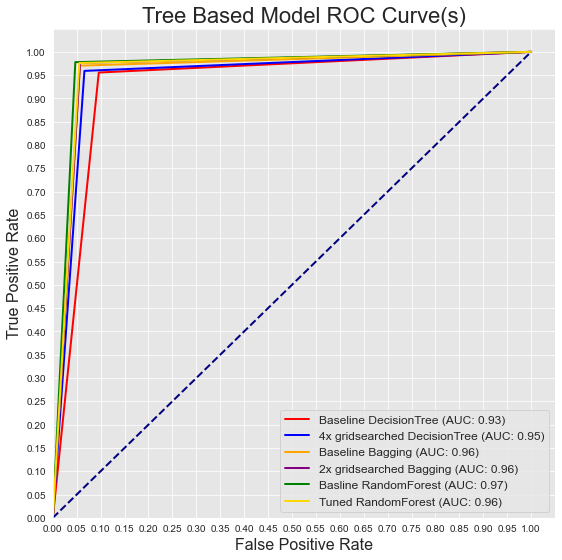

In [148]:
plt.figure(figsize=(9,9))
lw = 2

plt.plot(base_gridsearch_fpr, base_gridsearch_tpr, color='red',
         lw=lw, label=f'Baseline DecisionTree (AUC: {round(base_gridsearch_auc,2)})')
plt.plot(gridsearch_four_fpr, gridsearch_four_tpr, color='blue',
         lw=lw, label=f'4x gridsearched DecisionTree (AUC: {round(gridsearch_four_auc,2)})')
plt.plot(base_bagging_fpr,base_bagging_tpr, color='orange',
         lw=lw, label=f'Baseline Bagging (AUC: {round(base_bagging_auc,2)})')
plt.plot(second_grid_bagging_fpr,second_grid_bagging_tpr, color='purple',
         lw=lw, label=f'2x gridsearched Bagging (AUC: {round(second_grid_bagging_auc,2)})')        
plt.plot(base_rfc_fpr,base_rfc_tpr, color='green',
         lw=lw, label=f'Basline RandomForest (AUC: {round(base_rfc_auc,2)})')
plt.plot(tuned_rfc_fpr,tuned_rfc_tpr, color='gold',
         lw=lw, label=f'Tuned RandomForest (AUC: {round(tuned_rfc_auc,2)})')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Tree Based Model ROC Curve(s)',fontsize=22)
plt.legend(loc="lower right",prop={'size':12})

plt.show()

## True Positive rate

In [126]:
prediction_labels = ['Baseline\nDecisionTree',
                     '4x Gridsearched\nDecisionTree',
                     'Baseline Bagging',
                     '2x Gridsearched\nBagging',
                     'Baseline\nRandomForest',
                     'Tuned\nRandomForest']
predictions = [grid_pred,grid_four_pred,tree_bagger_pred,second_bagged_grid_pred,rfc_pred,rfc_tuned_pred]

tprs = []
fprs = []

tnrs = []
fnrs = []

for pred in predictions:
    matrix = confusion_matrix(y_test,pred,normalize='true')
    tprs.append(matrix[1][1])
    fprs.append(matrix[0][1])
    tnrs.append(matrix[0][0])
    fnrs.append(matrix[1][0])


<ipython-input-149-343fadc337f4>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(prediction_labels,fontsize=12)


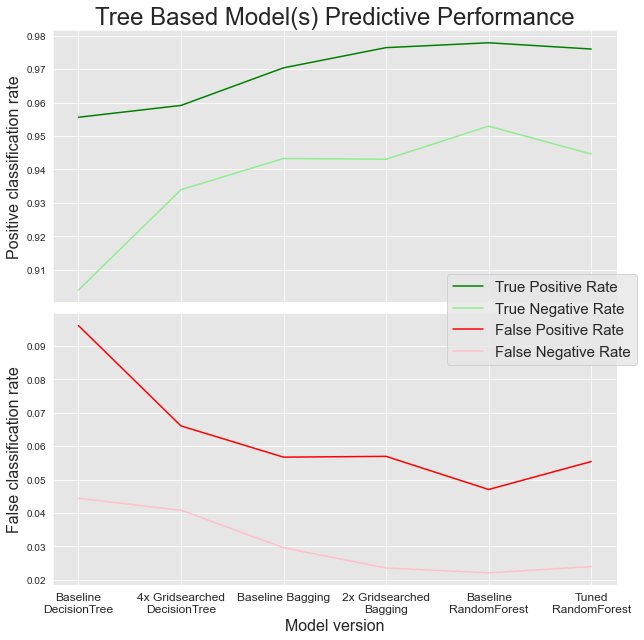

In [149]:
fig,(ax1,ax2) = plt.subplots(nrows=2,sharex=True)
ax1.set_title("Tree Based Model(s) Predictive Performance",fontsize=24)
ax1.plot(range(0,6),tprs,color='green',label='True Positive Rate')
ax1.plot(range(0,6),tnrs,color='lightgreen',label='True Negative Rate')

ax1.set_ylabel("Positive classification rate",fontsize=16)

ax2.plot(range(0,6),fprs,color='red',label='False Positive Rate')
ax2.plot(prediction_labels,fnrs,color='pink',label='False Negative Rate')

ax2.set_ylabel("False classification rate",fontsize=16)
ax2.set_xlabel("Model version",fontsize=16)

ax2.set_xticklabels(prediction_labels,fontsize=12)

fig.set_size_inches(9, 9)
fig.tight_layout()
fig.legend(loc='center right',prop={'size':15})
plt.show()